In [1]:
import os
os.chdir('/home/research/yu.zihao/pnp/ESE513_Final_Project/')
print(os.getcwd())

/home/research/yu.zihao/pnp/ESE513_Final_Project


In [2]:
from pnp import pnp_admm
from pnp import pnp_admm_record_images
from utils import conv2d_from_kernel, compute_psnr, ImagenetDataset, myplot
import matplotlib.pyplot as plt
import PIL.Image as Image

In [3]:
# Get sample
test_image = Image.open('figs/brookings.webp').convert("RGB")
test_image = ImagenetDataset([]).test_transform(test_image)
# test_image = dataset[1231]['target'] # from dataset
channels, h, w = test_image.shape
test_image = test_image.unsqueeze(0)
print(channels)
print(h)
print(w)

device = 'cpu' # BM3D packages seems to only suppot CPU

3
128
128


In [4]:
import torch
import bm3d
import numpy as np

def bm3d_denoiser(image_tensor, sigma=0.1):
    """
    BM3D denoiser for use in the PnP-ADMM framework.
    
    Args:
        image_tensor (torch.Tensor): The noisy image tensor (B, C, H, W) or (C, H, W).
        sigma (float): Noise standard deviation (controls the amount of denoising).
        
    Returns:
        torch.Tensor: The denoised image as a torch tensor.
    """
    # Check if the input has a batch dimension (4D tensor)
    if len(image_tensor.shape) == 4:  # [B, C, H, W]
        batch_size = image_tensor.shape[0]
        denoised_batch = []
        
        # Loop over each image in the batch and apply BM3D individually
        for i in range(batch_size):
            img = image_tensor[i]  # Get one image: [C, H, W]
            img_np = img.permute(1, 2, 0).cpu().numpy()  # Convert to [H, W, C] for BM3D

            # Prepare an empty array for the denoised image
            denoised_np = np.zeros_like(img_np)

            # Apply BM3D denoising to each channel independently
            for c in range(img_np.shape[2]):  # Loop over channels
                denoised_np[:, :, c] = bm3d.bm3d(img_np[:, :, c], sigma)

            # Convert back to PyTorch tensor
            denoised_img = torch.tensor(denoised_np).permute(2, 0, 1).to(image_tensor.device)  # Back to [C, H, W]
            denoised_batch.append(denoised_img)

        # Stack the denoised images back into a batch
        return torch.stack(denoised_batch)

    elif len(image_tensor.shape) == 3:  # [C, H, W] case (single image)
        img_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert to [H, W, C] for BM3D

        # Prepare an empty array for the denoised image
        denoised_np = np.zeros_like(img_np)

        # Apply BM3D denoising to each channel independently
        for c in range(img_np.shape[2]):  # Loop over channels
            denoised_np[:, :, c] = bm3d.bm3d(img_np[:, :, c], sigma)

        # Convert back to PyTorch tensor
        return torch.tensor(denoised_np).permute(2, 0, 1).to(image_tensor.device)  # Back to [C, H, W]


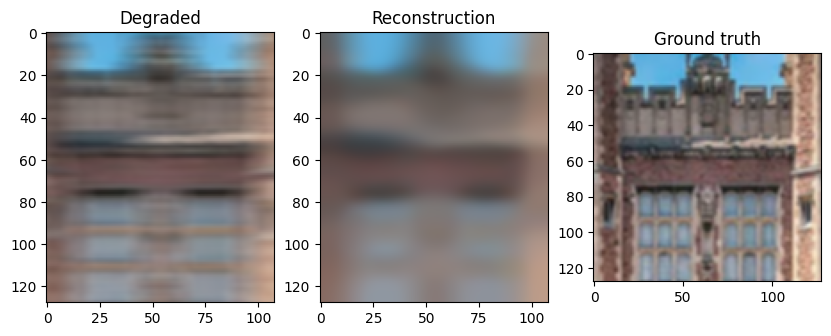

In [5]:
# Example usage with a single image
kernel_size = 21
kernel_motion_blur = torch.ones((1, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)

y = forward(test_image)
denoised_image = bm3d_denoiser(y, 1)

# Display
myplot(y, denoised_image, test_image)


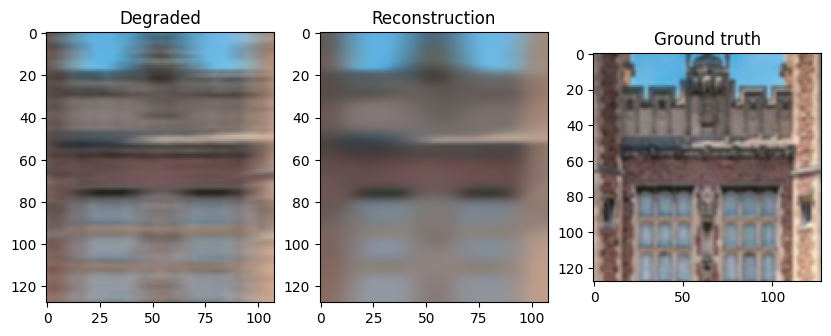

In [6]:
# Sigma = 0.3
kernel_size = 21
kernel_motion_blur = torch.ones((1, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)

y = forward(test_image)
denoised_image = bm3d_denoiser(y, 0.3)

# Display
myplot(y, denoised_image, test_image)


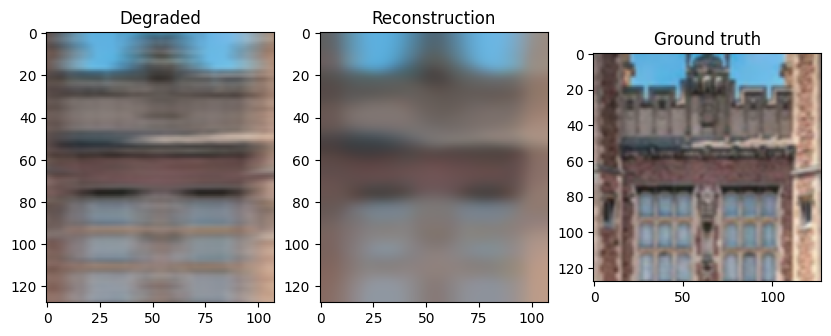

In [7]:
# Sigma = 1.0
kernel_size = 21
kernel_motion_blur = torch.ones((1, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)

y = forward(test_image)
denoised_image = bm3d_denoiser(y, 1.0)

# Display
myplot(y, denoised_image, test_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1664014..0.9545762].


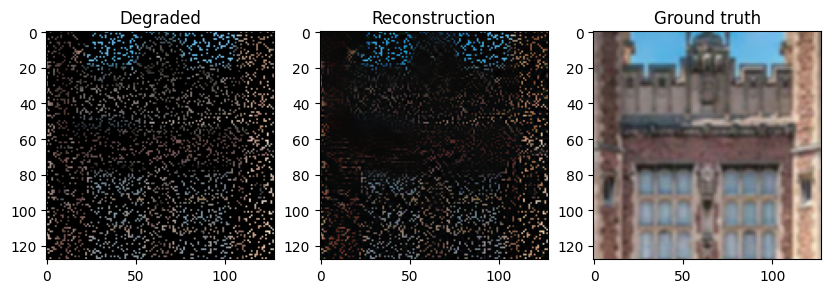

In [8]:
# Inpainting
mask = torch.rand(1,1,h,w).to(device)
mask = mask < 0.2

def forward(x):
    return x*mask
forward_adjoint = forward

# Run plug and play
y = forward(test_image)
denoised_image = bm3d_denoiser(y)

# Display
myplot(y, denoised_image, test_image)

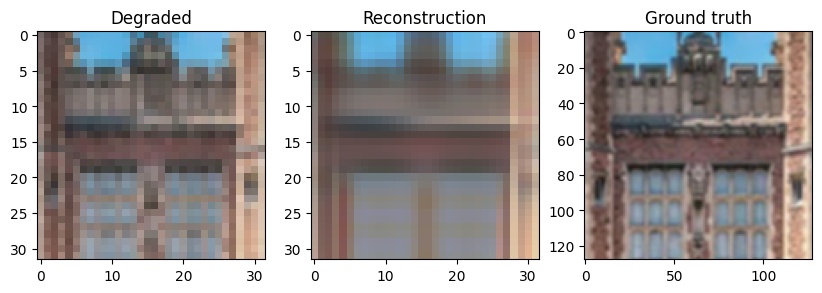

In [9]:
kernel_size = 4
kernel_downsampling = torch.ones((kernel_size, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_downsampling, channels, device, stride=kernel_size)

# Run plug and play
y = forward(test_image)
denoised_image = bm3d_denoiser(y)

# Display
myplot(y, denoised_image, test_image)